In [61]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
data_path = '2023030823_reddit.csv'

In [63]:
df = pd.read_csv(data_path)

In [64]:
spark = SparkSession.builder.appName("test") \
        .getOrCreate()

In [65]:
schema = StructType([StructField("post_id", StringType(), True)\
                    ,StructField("post_created_utc", StringType(), True)\
                    ,StructField("post_title", StringType(), True)
                    ,StructField("post_url", StringType(), True)\
                    ,StructField("artists_id", StringType(), True)\
                    ,StructField("artists_name", StringType(), True)\
                    ,StructField("track_id", StringType(), True)\
                    ,StructField("track_name", StringType(), True)\
                    ,StructField("release_date", StringType(), True)\
                    ,StructField("genres", StringType(), True)\
                    ,StructField("track_popularity", IntegerType(), True)\
                    ,StructField("danceability", FloatType(), True)\
                    ,StructField("energy", FloatType(), True)\
                    ,StructField("key", IntegerType(), True)\
                    ,StructField("mode", StringType(), True)\
                    ,StructField("loudness", FloatType(), True)\
                    ,StructField("speechiness", FloatType(), True)\
                    ,StructField("acousticness", FloatType(), True)\
                    ,StructField("instrumentalness", FloatType(), True)\
                    ,StructField("liveness", FloatType(), True)\
                    ,StructField("valence", FloatType(), True)\
                    ,StructField("tempo", FloatType(), True)\
                    ,StructField("duration_ms", IntegerType(), True)\
                    ,StructField("time_signature", IntegerType(), True)])

In [66]:
spark_df = spark.createDataFrame(df, schema = schema)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [67]:
spark_df = spark_df.na.drop()

In [68]:
assemble = VectorAssembler(inputCols=[
 'danceability',
 'energy',
 'loudness',
 'instrumentalness',
 'valence'], outputCol='features')

In [69]:
assembled_data = assemble.transform(spark_df)

In [10]:
assembled_data.show(2)

+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------------+--------------------+----------------+------------+------+---+----+--------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+--------------------+
|post_id|   post_created_utc|          post_title|            post_url|          artists_id|        artists_name|            track_id|track_name|release_date|              genres|track_popularity|danceability|energy|key|mode|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|            features|
+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------------+--------------------+----------------+------------+------+---+----+--------+-----------+------------+----------------+--------+-------+-------

In [11]:
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------------+--------------------+----------------+------------+------+---+----+--------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+--------------------+--------------------+
|post_id|   post_created_utc|          post_title|            post_url|          artists_id|        artists_name|            track_id|track_name|release_date|              genres|track_popularity|danceability|energy|key|mode|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|            features|        standardized|
+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------------+--------------------+----------------+------------+------+---+----+--------+-----------+------------

In [16]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed = 3)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.3989970824328103
Silhouette Score: 0.3658472400099648
Silhouette Score: 0.33170819133573687
Silhouette Score: 0.4010224266679344
Silhouette Score: 0.3962814082351836
Silhouette Score: 0.3567572002207501
Silhouette Score: 0.3774073487804149
Silhouette Score: 0.3243861504134223


Text(0.5, 1.0, 'silhouette score')

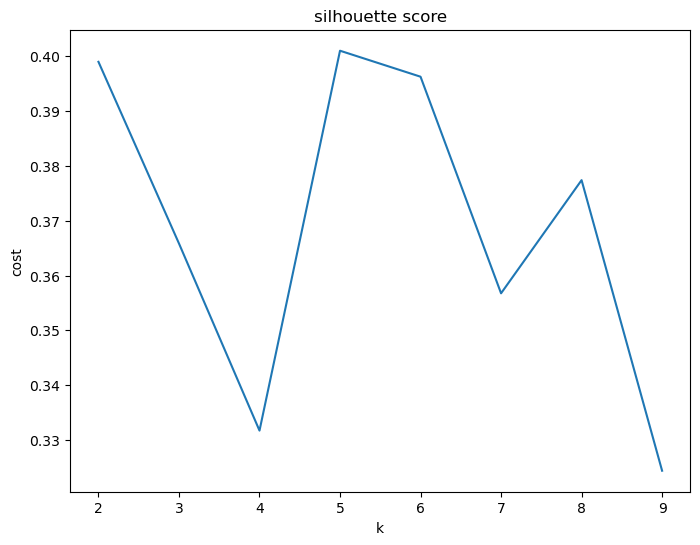

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('silhouette score')

Elbow Score: 440.96082258239966
Elbow Score: 377.9327027475433
Elbow Score: 329.3169068407986
Elbow Score: 271.2111135158218
Elbow Score: 247.16397059435386
Elbow Score: 232.90065778597355
Elbow Score: 212.64113333726613
Elbow Score: 202.88769441316043


Text(0.5, 1.0, 'Elbow Curve')

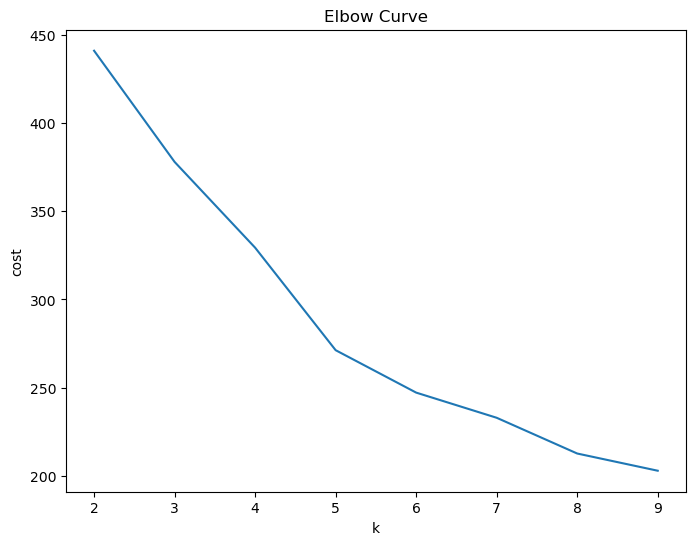

In [18]:
cost = []

for i in range(2,10):
    KMeans_algo = KMeans(featuresCol='standardized', k=i, seed = 3)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    score = KMeans_fit.summary.trainingCost
    cost.append(score)
    print("Elbow Score:",score)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost)
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('Elbow Curve')

In [19]:
KMeans_algo = KMeans(featuresCol = 'standardized', k = 5, seed = 3)
model = KMeans_algo.fit(data_scale_output)
predicted_df = model.transform(data_scale_output)

<Axes: xlabel='prediction', ylabel='danceability'>

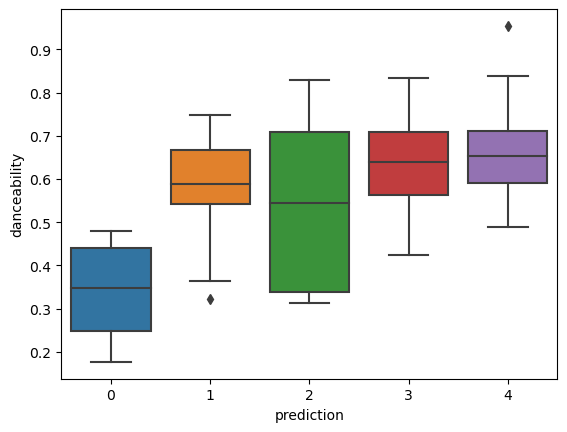

In [21]:
sns.boxplot(x = 'prediction', y = 'danceability', data = viz)

<Axes: xlabel='prediction', ylabel='energy'>

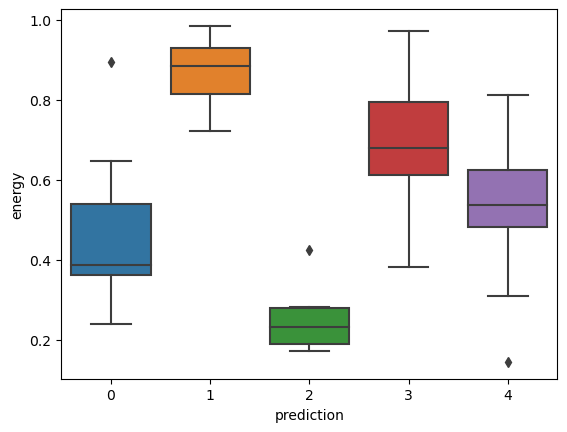

In [22]:
sns.boxplot(x = 'prediction', y = 'energy', data = viz)

<Axes: xlabel='prediction', ylabel='loudness'>

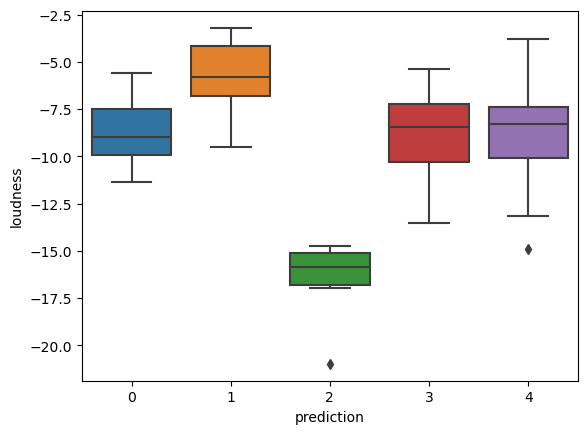

In [23]:
sns.boxplot(x = 'prediction', y = 'loudness', data = viz)

<Axes: xlabel='prediction', ylabel='instrumentalness'>

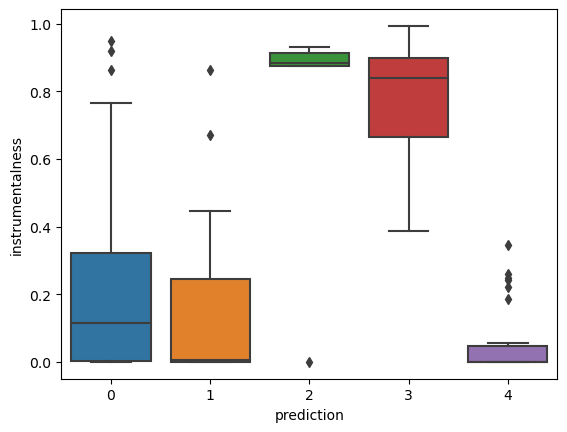

In [24]:
sns.boxplot(x = 'prediction', y = 'instrumentalness', data = viz)

<Axes: xlabel='prediction', ylabel='valence'>

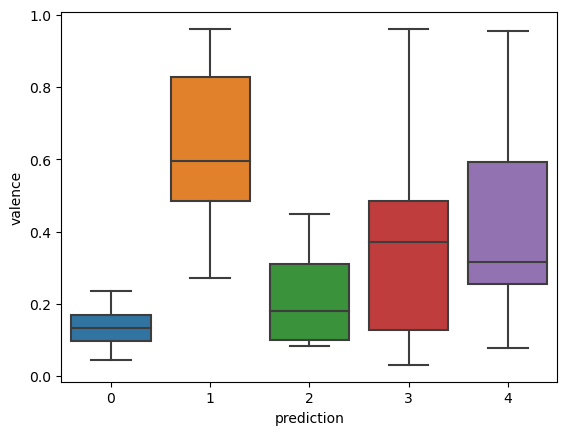

In [25]:
sns.boxplot(x = 'prediction', y = 'valence', data = viz)